# Table of Contents

[1. Data Importation & Cleaning](#1---data-importation)
- [1.1 - Relevant imports](#relevant-imports)
- [1.2 - Importing the datasets](#importing-the-datasets)
- [1.3 - Reaarangements & new columns](#rearrangements)
- [1.4 - Data cleaning](#data-cleaning)

[2. Exploratory Data Analysis](#2---exploratory-data-analysis)
- [2.1 Visualizing categorical & numerical variables](#visualizing-categorical--numerical-variables)
- [2.2 Visualizing numerical variables]()
- [2.3 Insights]()

[3. Machine Learning](#3---machine-learning)
- [3.1 - Classification Models](#classification-models)
    - [3.1.1 - Random Forest Classifier](#)
    - [3.1.2 - Support Vector Machine Classifier](#)
    - [3.1.3 - eXtreme Gradient Boosting Classifier](#)
    - [3.1.4 - Hyperparameter Tuning]()
        - [GridSearch]()
        - [RandomSearch]()
- [3.2 - Regression Models](#regression-models)
    - [3.1.1 - eXtreme Gradient Boosting Regressor](#)
    - [3.1.2 - gplearn Symbolic Regressor](#)
    -

## 1 - Data Importation

### Relevant imports

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Importing the datasets

In [5]:
data_list = []

for a in range(0, 5):
    file_path="data/dataset"+str(a+1)+".csv"
    data_list.append(pd.read_csv(file_path))

for a in range(0, len(data_list)):
    data_list[a].info()

new_col_names = ['G (m3/d)', 'P1 (MPa)', 'P2 (MPa)', 'ID (mm)', 'h (m)', 'Loading status']

for df in data_list:
    df.set_index("Well No.", inplace=True)
    df.columns = new_col_names

dataset = pd.DataFrame([])

dataset = pd.concat([df for df in data_list]).reset_index(drop=True).rename_axis('Well No.')

# Check the dataset
# dataset.info()
# dataset.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Well No.                    18 non-null     int64  
 1   Gas production (m3/d)       18 non-null     int64  
 2   Wellbore pressure (MPa)     18 non-null     float64
 3   Wellhead pressure (MPa)     18 non-null     float64
 4   Tubing inner diameter (mm)  0 non-null      float64
 5   Well depth (m)              18 non-null     int64  
 6   Loading status              18 non-null     object 
dtypes: float64(3), int64(3), object(1)
memory usage: 1.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Well No.                    90 non-null     int64  
 1   Gas production (m3/d)       90 non-null     f

## Rearrangements

The following code:
- imputes missing values for internal diameter using the modal value, since internal diameter is a fixed, constant and precalculated value
- imputes missing values for wellbore pressure using the average pressure difference from rows that have both wellbore and wellhead pressure data
- imputes missing values for well depth using the average value
- creates new columns for
    - pressure difference (delta_P, MPa) - P1 - P2
    - pressure gradient (P_grad, MPa/m) - $\frac{delta\_P}{h}$
    - cross-sectional area of well $(CSA, m^2) = {\pi}*(\frac{ID}{2})^2$, converted to relevant units
    - superficial velocity (sup_v, m/s) - $\frac{G}{A}$, converted to relevant units
- corrects column types

In [6]:
# Impute missing values for ID (mm)
dataset["ID (mm)"] = dataset["ID (mm)"].fillna(value=dataset["ID (mm)"].mode().iloc[0])

# Impute missing values for P1 (MPa)
dataset_temp_1 = dataset.dropna(subset=['P1 (MPa)'])
avg_p_diff = (dataset_temp_1['P1 (MPa)'] - dataset_temp_1['P2 (MPa)']).mean()
dataset["P1 (MPa)"] = dataset["P1 (MPa)"].fillna((dataset['P2 (MPa)'] + avg_p_diff))

# Impute missing values for h (m)
dataset_temp_2 = dataset.dropna(subset=['h (m)'])
avg_h = dataset_temp_2['h (m)'].mean()
dataset['h (m)'] = dataset['h (m)'].fillna(avg_h)

# Update column ID (mm)
dataset['ID (m)'] = dataset['ID (mm)'] / 1000

# Create new column, delta_P
dataset['delta_P (MPa)'] = np.abs(dataset['P1 (MPa)'] - dataset['P2 (MPa)'])

# Create new column, P_grad
dataset['P_grad (MPa / m)'] = dataset['delta_P (MPa)'] / dataset['h (m)']

# Create new column, CSA (m2)
dataset['CSA (m2)'] = dataset['ID (mm)'].apply(lambda x: np.pi * (x/2000)**2)

# Create new column, sup_v (m/s)
dataset['sup_v (m/s)'] = dataset['G (m3/d)'] / (dataset['CSA (m2)'] * 24 * 3600)

# Adjust type of col 'Loading status'
dataset['Loading status'] = dataset['Loading status'].str.strip().astype('category')
dataset["Loading status"] = dataset['Loading status'].cat.set_categories(["Unloaded", "Near Load Up", "Loaded Up"], ordered=True)

# print(dataset['Loading status'].value_counts(dropna=False))
dataset = dataset[['G (m3/d)', 'CSA (m2)', 'P1 (MPa)', 'P2 (MPa)', 'ID (m)', 'P_grad (MPa / m)', 'sup_v (m/s)', 'Loading status']]

# Check dataset
dataset.info()
dataset.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   G (m3/d)          263 non-null    float64 
 1   CSA (m2)          263 non-null    float64 
 2   P1 (MPa)          263 non-null    float64 
 3   P2 (MPa)          263 non-null    float64 
 4   ID (m)            263 non-null    float64 
 5   P_grad (MPa / m)  263 non-null    float64 
 6   sup_v (m/s)       263 non-null    float64 
 7   Loading status    263 non-null    category
dtypes: category(1), float64(7)
memory usage: 14.9 KB


,G (m3/d),CSA (m2),P1 (MPa),P2 (MPa),ID (m),P_grad (MPa / m),sup_v (m/s),Loading status
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Loaded Up
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,178
mean,45089.788631,0.005954,15.527154,8.690456,0.080641,0.002719,176.522217,NaN
std,63327.985526,0.005405,17.560292,9.071457,0.032900,0.005304,267.338577,NaN
min,0.000000,0.001521,0.840000,0.300000,0.044000,0.000039,0.000000,NaN
25%,0.000000,0.003019,7.436698,1.375000,0.062000,0.001500,0.000000,NaN
50%,16787.830000,0.003019,11.000000,4.600000,0.062000,0.002307,63.255303,NaN
75%,70421.125000,0.008012,20.821698,14.450000,0.101000,0.003293,254.381090,NaN


### Data cleaning

#### Observations
- a row of data was observed with 0 gas flowrate.  on closer observation, its wellhead pressure was also about 0.6 MPa. As such, calculated values like sup_v were also 0. The well was also marked as `Loaded Up`. This row of data is valid and would be left in the final dataset.
- Wellhead pressure had an extremely high value that should be removed as it significantly skews the mean and median

In [7]:
print(dataset.loc[dataset['P1 (MPa)'].idxmax()]['P1 (MPa)'])
# print(dataset.loc[dataset['P1 (MPa)'].idxmax()]['G (m3/d)'])
# print(dataset.loc[dataset['P1 (MPa)'].idxmax()]['sup_v (m/s)'])
# print("P1 stats before clean (max, min, avg)", dataset['P1 (MPa)'].max(), dataset['P1 (MPa)'].min(), dataset['P1 (MPa)'].mean())
dataset.drop(index=dataset['P1 (MPa)'].idxmax(), inplace=True)
# print("P1 stats after clean (max, min, avg)", dataset['P1 (MPa)'].max(), dataset['P1 (MPa)'].min(), dataset['P1 (MPa)'].mean())

# observations
print(dataset.loc[dataset['G (m3/d)'].idxmin()])

# Check dataset
dataset.info()
dataset.describe(include='all')

240.0
G (m3/d)                  0.0
CSA (m2)             0.009854
P1 (MPa)             7.236698
P2 (MPa)                  0.4
ID (m)               0.112014
P_grad (MPa / m)     0.003418
sup_v (m/s)               0.0
Loading status      Loaded Up
Name: 196, dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 262 entries, 0 to 262
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   G (m3/d)          262 non-null    float64 
 1   CSA (m2)          262 non-null    float64 
 2   P1 (MPa)          262 non-null    float64 
 3   P2 (MPa)          262 non-null    float64 
 4   ID (m)            262 non-null    float64 
 5   P_grad (MPa / m)  262 non-null    float64 
 6   sup_v (m/s)       262 non-null    float64 
 7   Loading status    262 non-null    category
dtypes: category(1), float64(7)
memory usage: 24.9 KB


,G (m3/d),CSA (m2),P1 (MPa),P2 (MPa),ID (m),P_grad (MPa / m),sup_v (m/s),Loading status
count,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Loaded Up
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177
mean,45142.421412,0.005965,14.670388,8.654542,0.080712,0.002403,176.737976,NaN
std,63443.423936,0.005412,10.758753,9.070066,0.032942,0.001379,267.827287,NaN
min,0.000000,0.001521,0.840000,0.300000,0.044000,0.000039,0.000000,NaN
25%,0.000000,0.003019,7.436698,1.337500,0.062000,0.001495,0.000000,NaN
50%,16787.830000,0.003019,10.868349,4.595000,0.062000,0.002300,63.255303,NaN
75%,70626.372500,0.008012,20.699198,14.327500,0.101000,0.003275,257.264059,NaN


## 2 - Exploratory Data Analysis

### Visualising Categorical & Numerical Variables


In [8]:
sns.set_palette('colorblind', 3)
figsize = (13.44, 7.56)

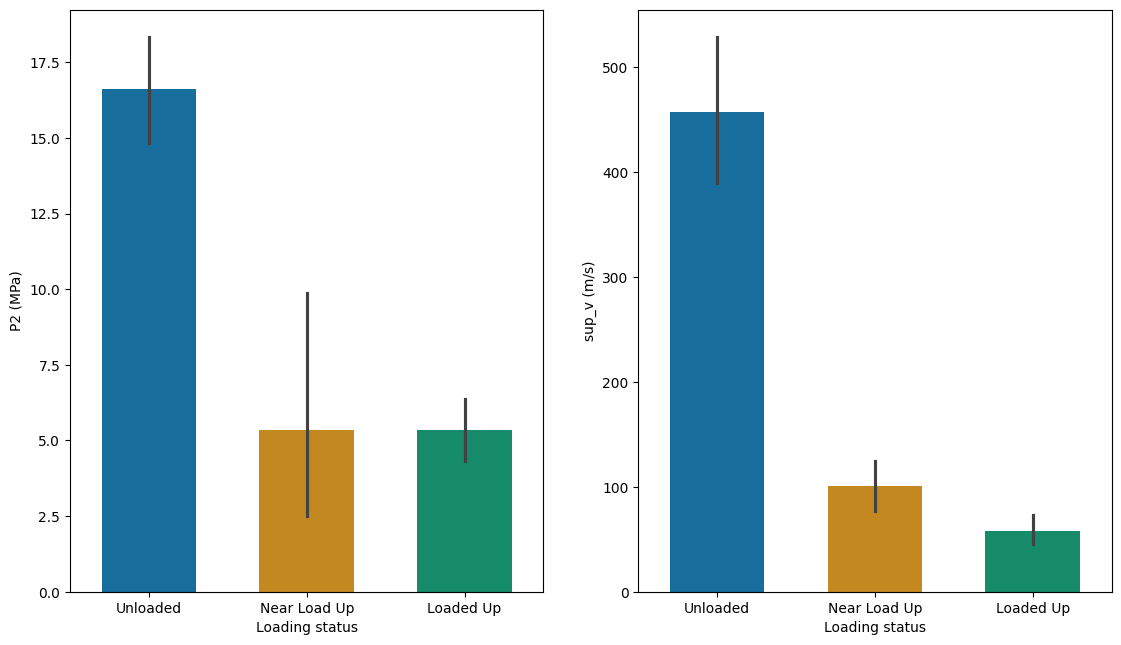

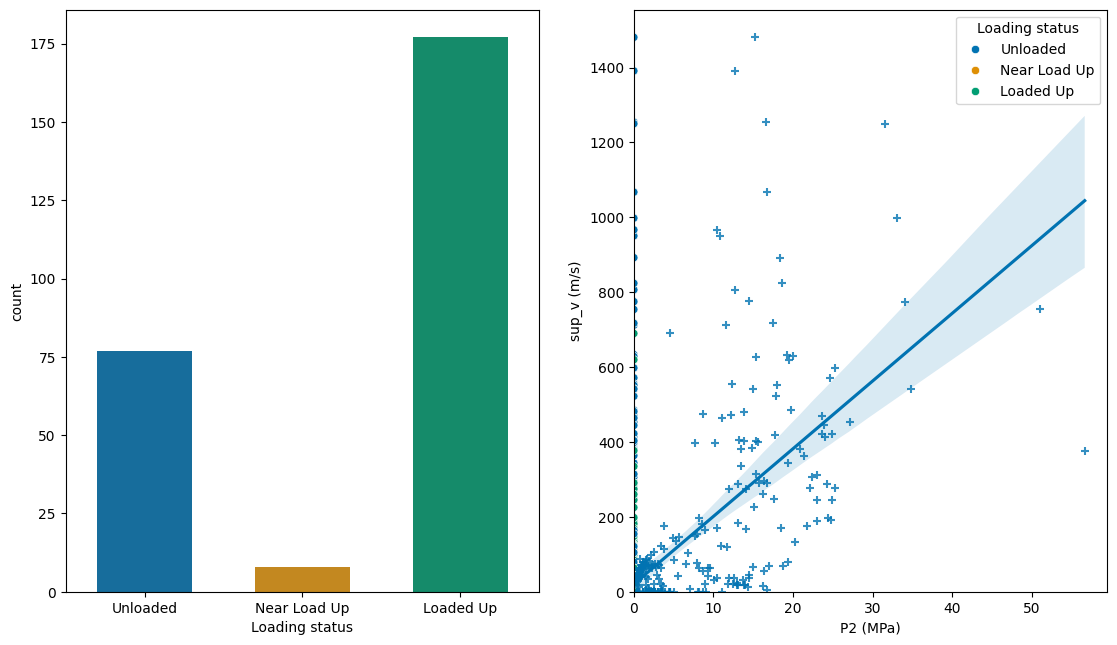

In [9]:
# Comparing average pressure and superficial vel. between categories
fig, axs = plt.subplots(1, 2, figsize=figsize)
sns.barplot(x='Loading status', y='P2 (MPa)', data=dataset, ax=axs[0], hue='Loading status', width=0.6)
sns.barplot(x='Loading status', y='sup_v (m/s)', data=dataset, ax=axs[1], hue='Loading status', width=0.6)

fig, axs = plt.subplots(1, 2, figsize=figsize)
sns.countplot(x='Loading status', data=dataset, ax=axs[0], hue='Loading status', width=0.6)
sns.scatterplot(dataset, x='P_grad (MPa / m)', y='sup_v (m/s)', ax=axs[1], hue='Loading status')


sns.regplot(dataset, x='P2 (MPa)', y='sup_v (m/s)', marker='+')

plt.xlim(0, )
plt.ylim(0, )

plt.show()

## 2.1 - Visualizing categorical & numerical variables

The charts above show a distinct difference in the wellhead pressure and superficial velocity of loaded wells, near-loaded, and unloaded wells. In both the pressure and superficial velocity bar charts, the loaded and near-loaded wells show a significantly lower value than unloaded wells. The relational plot between wellhead pressure and superficial velocity shows us two major things:
- There is a positive correlation between wellhead pressure and superficial velocity. This holds true whether the well is loaded, near-loaded or unloaded.
- The unloaded wells have much higher values of both wellhead pressure and superficial velocity, while wells marked as near-loaded and loaded have lower values.

This reestablishes the idea that loading is due to a significant reduction in pressure, leading to a drop in superficial velocity

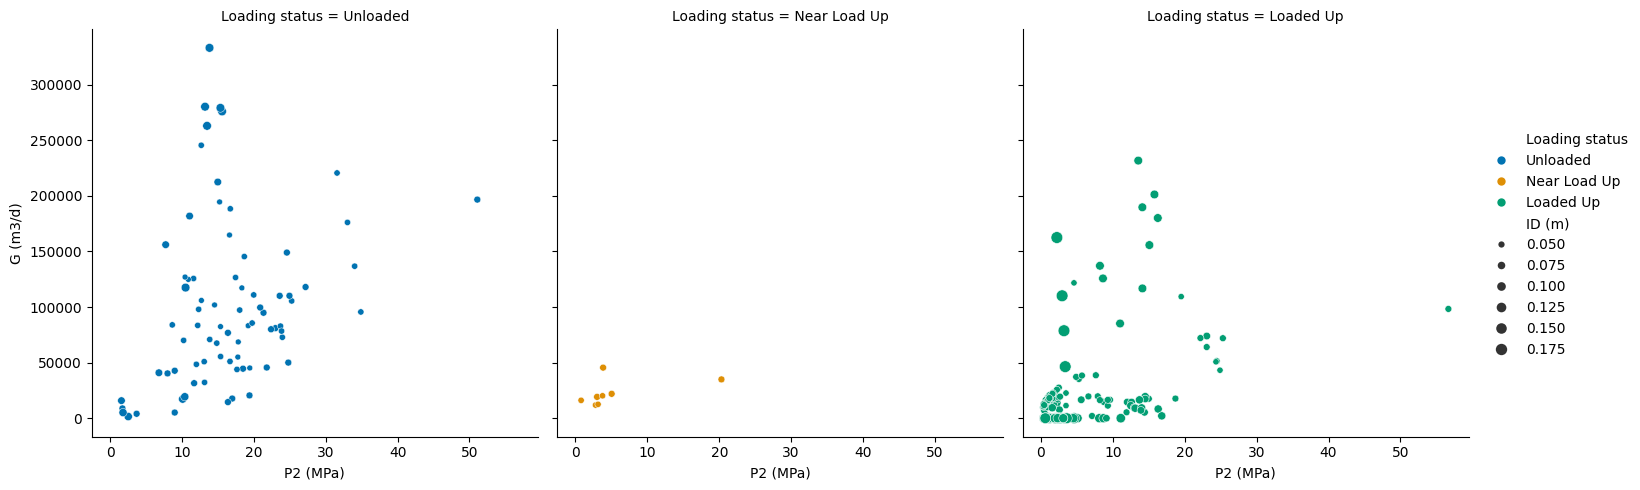

In [10]:
# fig, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.relplot(x="P2 (MPa)", y="G (m3/d)", data=dataset, kind="scatter", size='ID (m)', col='Loading status', hue="Loading status")

plt.show()

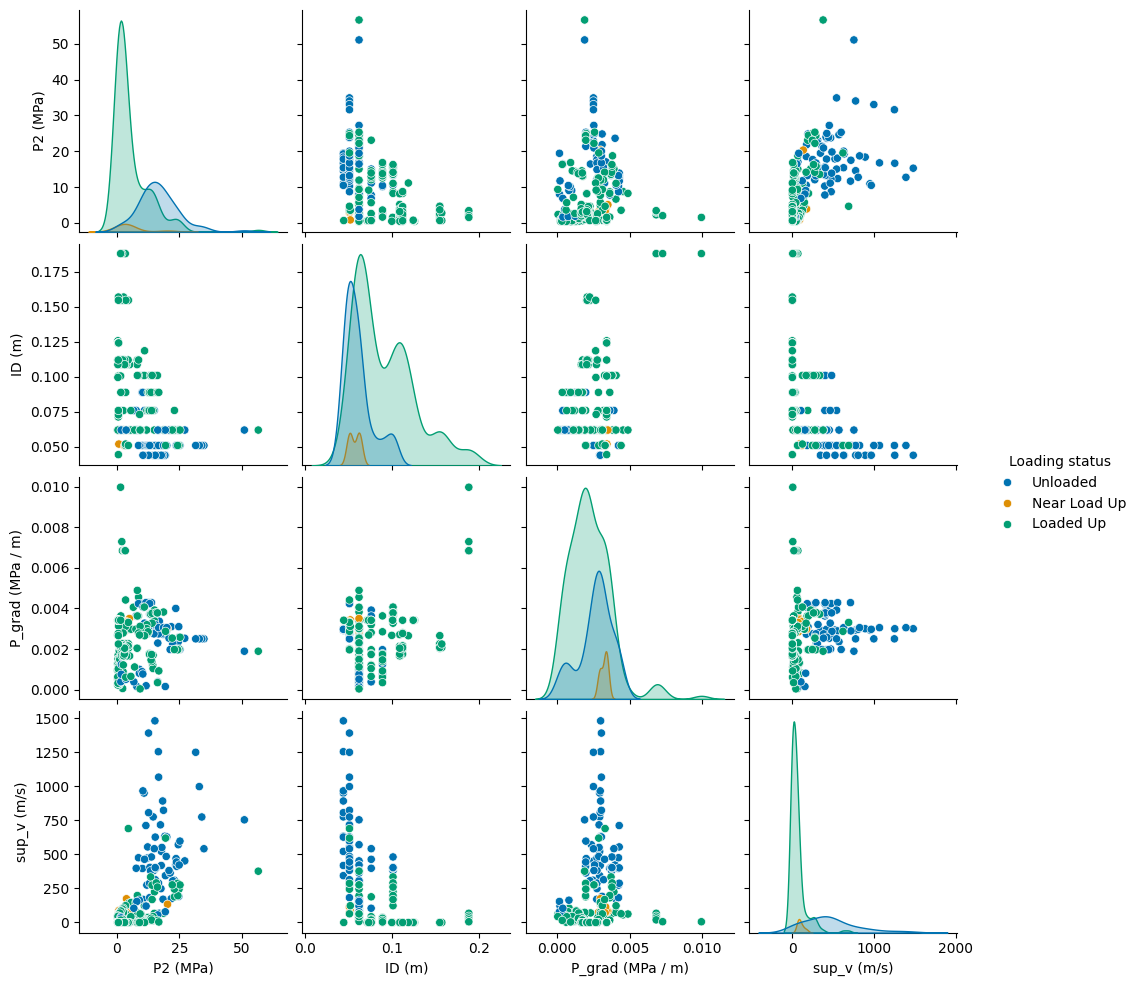

In [12]:
sns.pairplot(dataset.drop(columns=['P1 (MPa)', 'G (m3/d)', 'CSA (m2)'], axis=1), hue='Loading status')
plt.show()

<Axes: >

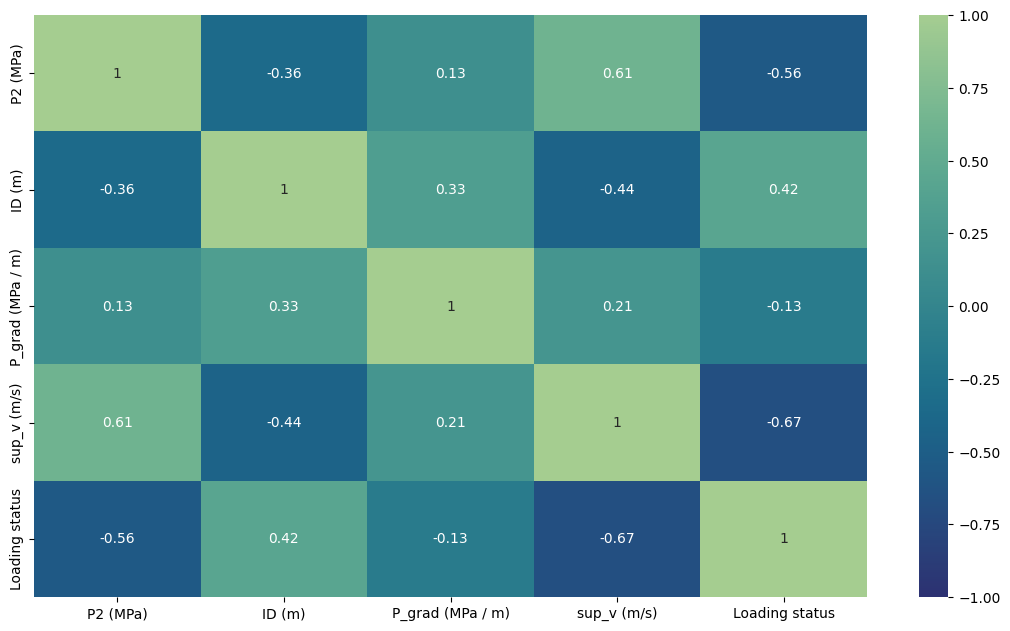

In [16]:
plt.figure(figsize=figsize)

dataset_heat = dataset.drop(columns=['G (m3/d)', 'CSA (m2)', 'P1 (MPa)'])
dataset_heat['Loading status'] = dataset_heat['Loading status'].str.replace('Loaded Up', '2')
dataset_heat['Loading status'] = dataset_heat['Loading status'].str.replace('Near Load Up', '1')
dataset_heat['Loading status'] = dataset_heat['Loading status'].str.replace('Unloaded', '0')
dataset_heat['Loading status'] = dataset_heat['Loading status'].astype('category')

sns.heatmap(dataset_heat.corr(), annot=True, vmin=-1, vmax=1, cmap='crest_r')
plt.show()

## 3 - Machine Learning

#### Relevant Imports

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.tree import export_graphviz

#### Data pre-processing

In [29]:
columns_to_keep = ['P2 (MPa)', 'ID (m)', 'P_grad (MPa / m)', 'sup_v (m/s)', 'Loading status']
dataset = dataset[columns_to_keep]

dataset['Loading status'] = dataset['Loading status'].astype('category')
dataset['Loading status'] = dataset['Loading status'].cat.set_categories(['Unloaded', 'Near Load Up', 'Loaded Up'], ordered=True)

label_encoder = LabelEncoder()
dataset['Loading status'] = label_encoder.fit_transform(dataset.loc['Loading status'])

print(dataset.head())

In [19]:
X = dataset.drop('Loading status', axis=1).values
y = dataset['Loading status'].values
seed = 21

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

### Classification Models
#### RandomForest Classifier

84.61538461538461% accuracy!
Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        27
           1       0.50      1.00      0.67         1
           2       0.80      0.73      0.76        11

    accuracy                           0.85        39
   macro avg       0.73      0.87      0.77        39
weighted avg       0.85      0.85      0.85        39

    0  1  2
0  24  1  2
1   0  1  0
2   3  0  8


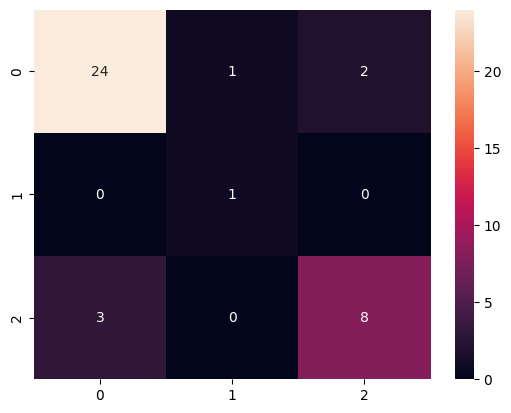

In [20]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=seed)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print(f"{accuracy*100}% accuracy!")

report = classification_report(y_test, y_pred)
print("Classification Report: ")
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(data=pd.DataFrame(conf_matrix), annot=True)
# print(conf_matrix)
print(pd.DataFrame(conf_matrix))

82.05128205128204% accuracy!
Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        27
           1       0.50      1.00      0.67         1
           2       0.73      0.73      0.73        11

    accuracy                           0.82        39
   macro avg       0.70      0.86      0.75        39
weighted avg       0.83      0.82      0.82        39



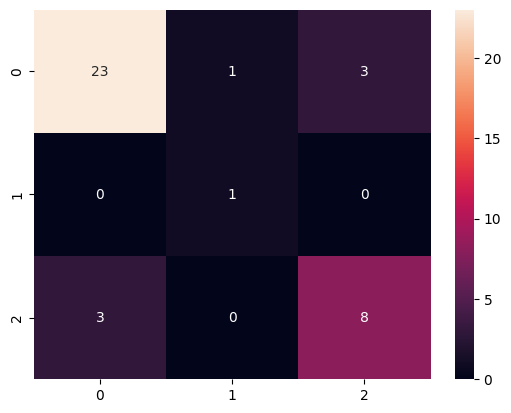

In [21]:
# RandomForest with scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

rf_classifier.fit(X_train_scaled, y_train)

y_pred_scaled = rf_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_scaled)
print(f"{accuracy*100}% accuracy!")

report = classification_report(y_test, y_pred_scaled)
print("Classification Report: ")
print(report)

conf_matrix = confusion_matrix(y_test, y_pred_scaled)
sns.heatmap(data=pd.DataFrame(conf_matrix), annot=True)
plt.show()

#### Support Vector Machine Classifier

82.05128205128204% accuracy!


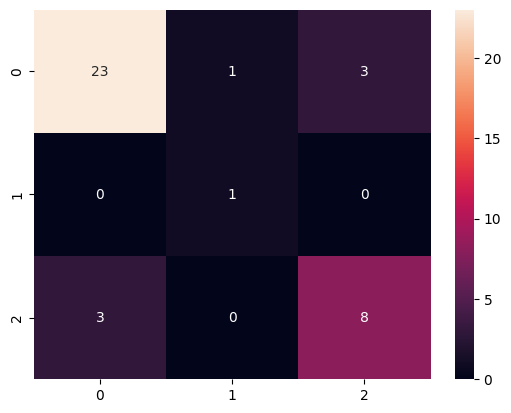

In [22]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='rbf', random_state=seed)

svm_classifier.fit(X_train_scaled, y_train)

y_pred = svm_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_scaled)
print(f"{accuracy*100}% accuracy!")

conf_matrix = confusion_matrix(y_test, y_pred_scaled)
sns.heatmap(data=pd.DataFrame(conf_matrix), annot=True)
plt.show()

#### Extreme Gradient Boosting Classifier

In [23]:
from xgboost import XGBClassifier

82.05128205128204% accuracy!


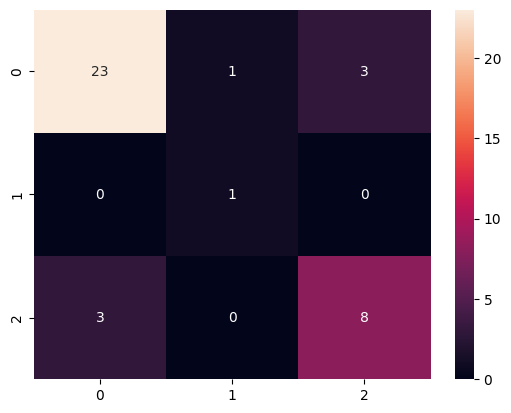

In [24]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print(f"{accuracy*100}% accuracy!")

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(data=pd.DataFrame(conf_matrix), annot=True)
plt.show()

#### Hyperparameter tuning

##### Using Grid Search

In [25]:
from sklearn.model_selection import GridSearchCV

grid = {'n_estimators': [10, 50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.5, 0.8, 1]
}

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=grid, cv=10, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"Best cv score: {grid_search.best_score_}")

Fitting 10 folds for each of 81 candidates, totalling 810 fits


c:\Users\Angel\Desktop\School\Y5\S2\Project II - PGG 588\Actual Project Code\liquid-loading-prediction-model\myenv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
Best cv score: 0.8687134502923979


In [26]:
grid_best_params = grid_search.best_params_

best_xgb_classifier = XGBClassifier(
    n_estimators=grid_best_params['n_estimators'],    
    learning_rate=grid_best_params['learning_rate'],
    max_depth=grid_best_params['max_depth'],
    # min_child_weight=grid_best_params['min_child_weight'],
    subsample=grid_best_params['subsample'],
    # colsample_bytree=grid_best_params['colsample_bytree'],
    # gamma=grid_best_params['gamma'],
    # scale_pos_weight=grid_best_params['scale_pos_weight']
)

best_xgb_classifier.fit(X_train, y_train)

y_pred = best_xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print(f"{accuracy*100}% accuracy!")

82.05128205128204% accuracy!


Using Grid

##### Using Random Search

In [27]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators': [10, 50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.5, 0.8, 1]
}

random_search = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=random_grid, n_iter=1000, cv=10, n_jobs=-1, verbose=1, random_state=seed)

random_search.fit(X_train, y_train)

rand_best_params = random_search.best_params_
print(f"Best params: {rand_best_params}")

c:\Users\Angel\Desktop\School\Y5\S2\Project II - PGG 588\Actual Project Code\liquid-loading-prediction-model\myenv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 81 is smaller than n_iter=1000. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 81 candidates, totalling 810 fits


c:\Users\Angel\Desktop\School\Y5\S2\Project II - PGG 588\Actual Project Code\liquid-loading-prediction-model\myenv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Best params: {'subsample': 0.5, 'n_estimators': 10, 'max_depth': 3, 'learning_rate': 0.1}


In [28]:
best_xgb_classifier = XGBClassifier(
    n_estimators=rand_best_params['n_estimators'],    
    learning_rate=rand_best_params['learning_rate'],
    max_depth=rand_best_params['max_depth'],
    # min_child_weight=rand_best_params['min_child_weight'],
    subsample=rand_best_params['subsample'],
    # colsample_bytree=rand_best_params['colsample_bytree'],
    # gamma=rand_best_params['gamma'],
    # scale_pos_weight=rand_best_params['scale_pos_weight']
)

best_xgb_classifier.fit(X_train, y_train)

y_pred = best_xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print(f"{accuracy*100}% accuracy!")

82.05128205128204% accuracy!


In [ ]:
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor(n_estimators=1000, learning_rate=0.1)

xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"RMSE: {np.sqrt(mse)}, " + r"R^2" + f": {r2}, MAPE: {mape}%")

In [ ]:
from gplearn.genetic import SymbolicRegressor

# final_dataset['Loading status'].astype('category')
# final_dataset["Loading status"] = final_dataset['Loading status'].cat.set_categories(["Unloaded", "Near Load Up", "Loaded Up"], ordered=True)

# unseen_data['Loading status'].astype('category')
# unseen_data["Loading status"] = unseen_data['Loading status'].cat.set_categories(["Unloaded", "Near Load Up", "Loaded Up"], ordered=True)
# unseen_data['Loading status'] = unseen_data['Loading status'].astype(int)

# print(final_dataset['Loading status'].head(), unseen_data['Loading status'].head())


X = dataset.drop('sup_v (m/s)', axis=1).values
y = dataset['sup_v (m/s)'].values
seed = 21

# X_val = unseen_dummy.drop('sup_v (m/s)', axis=1).values
# y_val = unseen_dummy['sup_v (m/s)'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [ ]:
symb_regressor = SymbolicRegressor(population_size=5000,
                                   generations=20,
                                   p_crossover=0.7,
                                   max_samples=0.9,
                                   parsimony_coefficient=0.01,
                                   random_state=seed)

symb_regressor.fit(X_train, y_train)
y_pred = symb_regressor.predict(X_test)

In [ ]:
plt.scatter(X_test[:, 0], y_test, c='salmon', label='Actual Data', s=12.5)
plt.scatter(X_test[:, 0], y_pred, c='blue', label='Model Data', s=12.5, marker='x')

plt.xlabel("wellhead pressure")
plt.ylabel("superficial velocity")
plt.xlim(0, 30)
plt.ylim(0, 1500)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"RMSE: {np.sqrt(mse)}, Mean Absolute % Eror: {mape}")

symb_reg_func = symb_regressor._program
print(f"Best function: {symb_reg_func}")
print(f"Score?: {symb_reg_func.score(X_test, y_test)}")

plt.show()

In [ ]:
columns_to_keep.pop()

tree.export_graphviz(symb_regressor.fit(X_train, y_train), out_file='model.dot', feature_names=columns_to_keep)